In [125]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from venn import venn
from collections import Counter
from matplotlib.colors import DivergingNorm

In [126]:
### Load data: absrel GO enrichemnts
v = 'combined_default_srv_mh' 
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{}/ClusterProfiler/'.format(v)

nectar_clades    = ['hmmbrds', 'nectar_parrots', 'honeyeaters', 'sunbirds']
nonnectar_clades = ['swifts', 'falcons', 'lyrebirds', 'passerides']

all_results = {}

clades = nectar_clades + nonnectar_clades
for clade in clades:
    file_name = 'gene_hg38.goenrich.{}.under_selection_per_clade_0.05.tsv'.format(clade)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    all_results[clade] = df

In [50]:
### Load data: RNAseq GO enrichemnts
v = 'Intra_species_DESeq2_results'
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/{}/ClusterProfiler/'.format(v)

nectar_clades    = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']
nonnectar_clades = ['common_swift', 'zebra_finch', 'cockatiel']

all_results = {}
# t = 'liver'
t = 'pectoralis'


clades = nectar_clades + nonnectar_clades
for clade in clades:
    file_name = 'goenrich.up_{}_genes_{}_not_*.tsv'.format(t, clade)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    all_results[clade] = df

In [112]:
### Count in how many groups each GO is present

def count_gos(clades):
    all_goids = []
    for clade in clades:
        all_goids.extend(all_results[clade][all_results[clade]['pvalue'] < 0.05]['ID'])
    return Counter(all_goids)

nonnectar_go_count = count_gos(nonnectar_clades)
nectar_go_count = count_gos(nectar_clades)

rank3_nonnectar_go = [k for k in nonnectar_go_count if nonnectar_go_count[k] >= 3]
rank2_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] >= 2]
rank3_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] >= 3]
print(len(rank3_nonnectar_go))
print(len(rank2_nectar_go))
print(len(rank3_nectar_go))


11
97
19


In [120]:
### Exclude control GO ids from target

data_rank3_nectar = {}
for clade in nectar_clades:
    df_clade = all_results[clade]
    filt_df_clade = df_clade[(df_clade['ID'].isin(rank3_nectar_go) 
                              & (~df_clade['ID'].isin(rank3_nonnectar_go)))][['ID', 'Description', 'pvalue']]
    data_rank3_nectar[clade] = filt_df_clade
    
merged_df = pd.DataFrame({'ID': [], 'Description': []})
for clade in data_rank3_nectar:
    df = data_rank3_nectar[clade]
    df['logP_{}'.format(clade)] = np.log10(df['pvalue'])
    df.drop('pvalue', axis=1, inplace=True)
    merged_df = pd.merge(merged_df, df, on=['ID', 'Description'], how='outer')
    merged_df.set_index('Description', inplace=True)

In [56]:
## Exclude immidiate children
to_exclude_nonnectar = ['GO:0002283', 'GO:0032640', 'GO:0032680', 'GO:0032760', 'GO:0032944', 
                        'GO:0032946', 'GO:0046651', 'GO:0050670', 'GO:0050671', 'GO:0070665', 
                        'GO:0071404', 'GO:1903557', 'GO:0005996']
to_exclude = to_exclude_nonnectar

merged_df = merged_df[~merged_df['ID'].isin(to_exclude)]

/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  if __name__ == '__main__':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


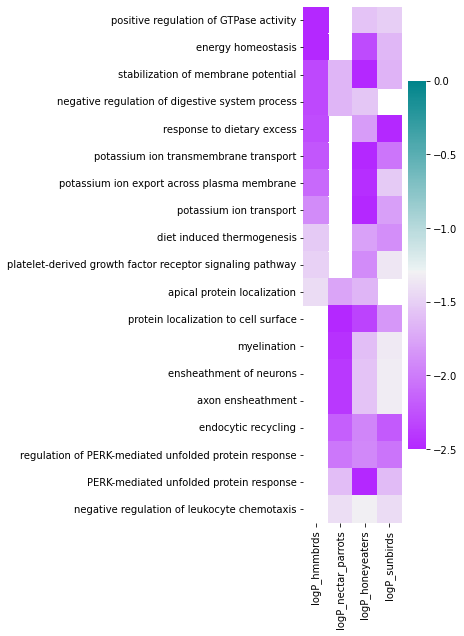

In [122]:
## purple color palette
cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)

## absrel
vmin = -2.5
## RANseq
# vmin = -5

divnorm_pval = DivergingNorm(vmin=vmin, vmax=0, vcenter=np.log10(0.051))

pval_cols = [i for i in merged_df.columns if i.startswith('logP_')]
df_pval = merged_df[pval_cols]

fig, axes = plt.subplots(figsize=(2.2, len(merged_df)/2))
sns.heatmap(data=df_pval, cmap=cmap_pval, norm=divnorm_pval)

# axes.set_xticklabels(df_pval['GO'])
axes.set_ylabel('')
fig.tight_layout()

# pdf_name = 'clusterProfiler.absrel_2024_results.4_lists.pdf'
# pdf_name = 'clusterProfiler.intra_nectar_{}_2024_results.pdf'.format(t)

plt.savefig(pdf_name, format='pdf', bbox_inches="tight")

In [77]:
### Load data: RNAseq GO enrichemnts
v = 'DESeq2_results_Kallisto'
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/{}/ClusterProfiler/'.format(v)

nectar_clades    = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']

all_results = {}
directions = ['up', 'down']
tissues = ['liver', 'pectoralis', 'duodenum', 'heart']

clades = nectar_clades

for d in directions:
    for clade in clades:
        for t in tissues:
            file_name = 'goenrich.{}.{}.{}.top_0.05.tsv'.format(d, clade, t)
            file_data = glob(dir_path + file_name)[0]
            df = pd.read_csv(file_data, sep='\t')
            all_results[(d, clade, t)] = df

In [97]:
def count_gos(clades, d, t):
    all_goids = []
    for clade in clades:
        all_goids.extend(all_results[(d, clade, t)][all_results[(d, clade, t)]['pvalue'] < 0.05]['ID'])
    return Counter(all_goids)

all_merged_dfs = {}
rank = 2
# rank = 3

for d in directions:
    for t in tissues:
        nectar_go_count = count_gos(nectar_clades, d, t)
        rank_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] == rank]
        
        data_rank_nectar = {}
        for clade in nectar_clades:
            df_clade = all_results[(d, clade, t)]
            filt_df_clade = df_clade[(df_clade['ID'].isin(rank_nectar_go))][['ID', 'Description', 'pvalue']]
            data_rank_nectar[clade] = filt_df_clade

        merged_df = pd.DataFrame({'ID': [], 'Description': []})
        for clade in data_rank_nectar:
            df = data_rank_nectar[clade]
            df['logP_{}'.format(clade)] = np.log10(df['pvalue'])
            df.drop('pvalue', axis=1, inplace=True)
            if not(df.empty):
                merged_df = pd.merge(merged_df, df, on=['ID', 'Description'], how='outer')
                merged_df.set_index('Description', inplace=True)
        all_merged_dfs[(d, t)] = merged_df
        
        ## write merged data to file
        ouf = '{}/rank{}.goenrich.{}.all_nectar.{}.top_0.05.tsv'.format(dir_path, rank, d, t)
        merged_df.to_csv(ouf, sep='\t')

In [102]:
df

,Description,ID,logP_Annas_hummingbird,logP_New_Holland_honeyeater,logP_rainbow_lorikeet
0,branched-chain amino acid metabolic process,GO:0009081,-4.896329,-2.047873,-2.328117
1,branched-chain amino acid catabolic process,GO:0009083,-4.459727,-1.552849,-1.762463
2,fatty acid metabolic process,GO:0006631,-1.601745,-1.405664,-3.224931


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  app.launch_new_instance()
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


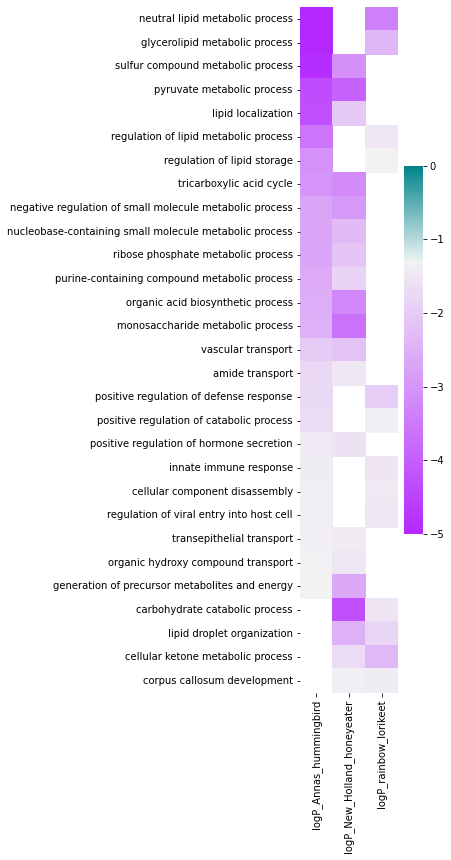

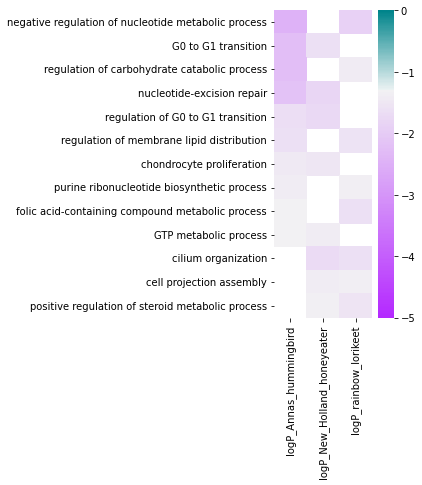

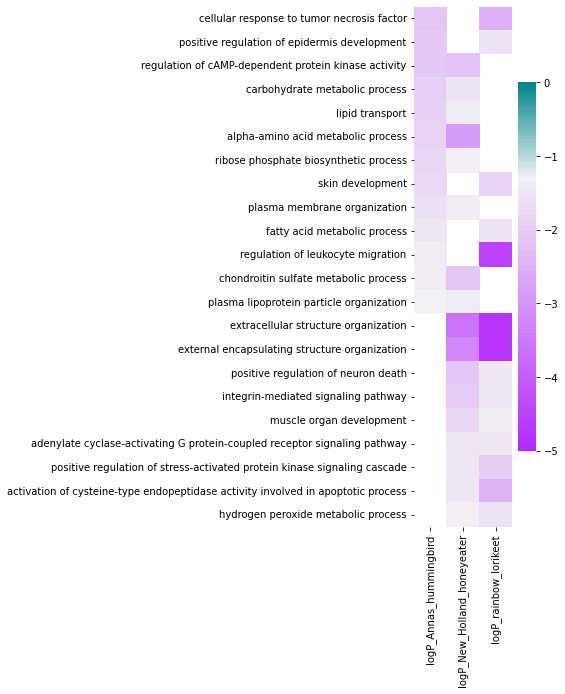

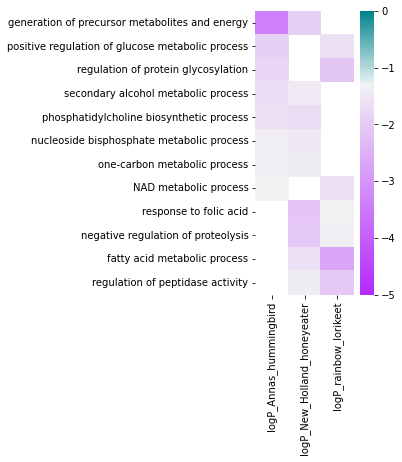

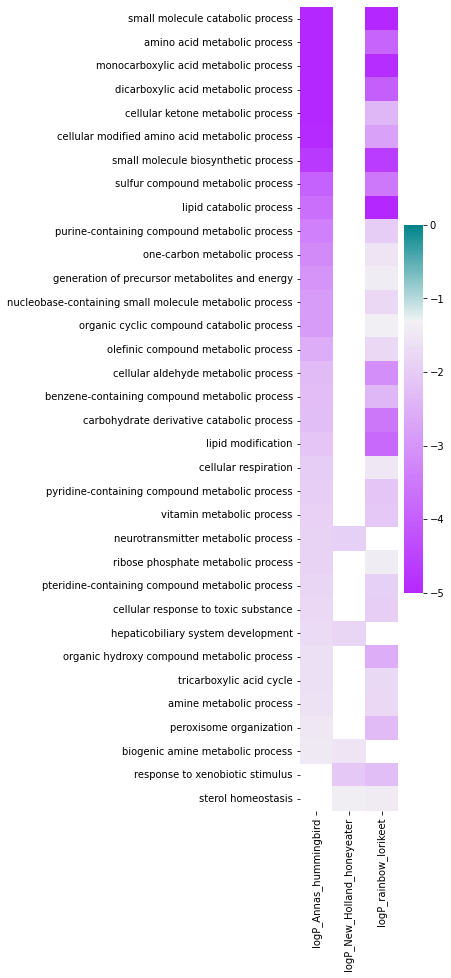

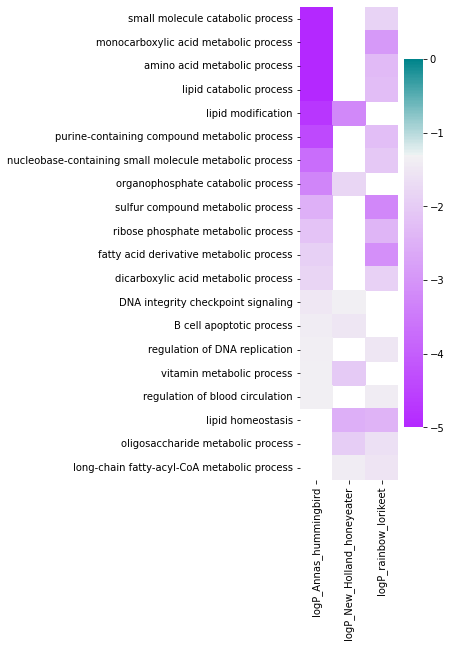

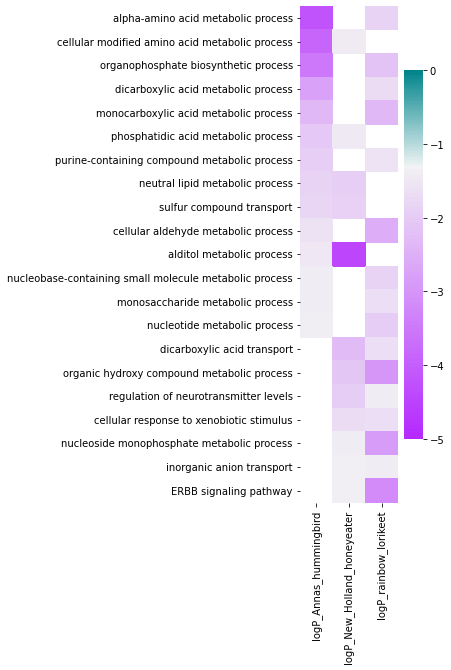

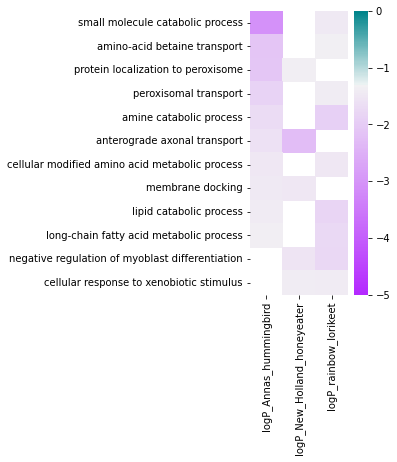

In [105]:
## Plot
rank = 3
rank = 2

for d in directions:
    for t in tissues:
        file_name = 'noChildren.rank{}.goenrich.{}.all_nectar.{}.top_0.05.tsv'.format(rank, d, t)
        file_data = glob(dir_path + file_name)[0]
        df = pd.read_csv(file_data, sep='\t')
        df.set_index('Description', inplace=True)
        
        if not(df.empty):
            cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)
            vmin = -5

            divnorm_pval = DivergingNorm(vmin=vmin, vmax=0, vcenter=np.log10(0.051))

            pval_cols = [i for i in df.columns if i.startswith('logP_')]
            df_pval = df[pval_cols]

            fig, axes = plt.subplots(figsize=(2.2, len(df)/2.3))
            sns.heatmap(data=df_pval, cmap=cmap_pval, norm=divnorm_pval)

            # axes.set_xticklabels(df_pval['GO'])
            axes.set_ylabel('')
            fig.tight_layout()

            pdf_name = '{}/rank{}.goenrich.{}.all_nectar.{}.top_0.05.pdf'.format(dir_path, rank, d, t)
#             plt.savefig(pdf_name, format='pdf', bbox_inches="tight")

In [124]:
## GO Enrichmens. ClusterProfiler
v = 'combined_default_srv_mh'
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{}/ClusterProfiler/'.format(v)
dbs = ['1.nectar', '2.nectar', '3.nectar', '4.nectar']

# q_cutoff = 0.5
# p_cutoff = 0.5
# count_cutoff = 4
# count_cutoff = 3

## Load data
DF_dbs = {}
nonzero_dbs = []
for db in dbs:
#     file_name = 'PopGen_{}/SF2.go_enrich.1Mb_domain.tsv'.format(db)
    file_name = 'represent_GO.rank{}.tsv'.format(db)
    print(file_name)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    df = df[df['p.adjust'] < p_cutoff]
    df = df[df['Count'] >= count_cutoff]
    
    if df.shape[0] > 0:
        print('yes')
        df['GOfull'] = df['Description'] + '  ' + df['ID']
        df['logpval'] = - np.log10(df['pvalue'])
        df['ngenes'], df['nset'] = df['GeneRatio'].str.split('/').str
        df['ratio'] = (pd.to_numeric(df['ngenes']) / pd.to_numeric(df['nset']) * 1000).astype(int)
        DF_dbs[db] = df
        nonzero_dbs.append(db)


## Plot barplots p-value DoS > 0 and DoS < 0
db_ratios = [DF_dbs[db].shape[0] for db in nonzero_dbs]
fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': db_ratios}, 
                         figsize=(4, 6*len(nonzero_dbs)))

blue = '#2b83ba'
red = '#d7191c'
c = 'purple'
min_ratio = 50
max_ratio = 150

i = 0
for db in nonzero_dbs:
    axi = axes[i]
    dfi = DF_dbs[db]
    sns.scatterplot(ax=axi, data=dfi, x='logpval', y='Description', size='ratio',
                    sizes=(min_ratio, max_ratio), color=c, alpha=0.7, linewidth=0)
    axi.set(xlim=(1.5, 8.5), ylabel='')
    axi.set_title(db)
    axi.legend([], [], frameon=False)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False) 
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)
fig.tight_layout()

pdf_name = 'SF2.enrichGO.withBG.clusterProfiler.1Mb_domain.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')

represent_GO.rank1.nectar.tsv


KeyError: 'p.adjust'

represent_GO.rank1.nonnectar.tsv
yes
represent_GO.rank2.nonnectar.tsv
yes
represent_GO.rank3.nonnectar.tsv
yes
represent_GO.rank4.nonnectar.tsv
yes


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


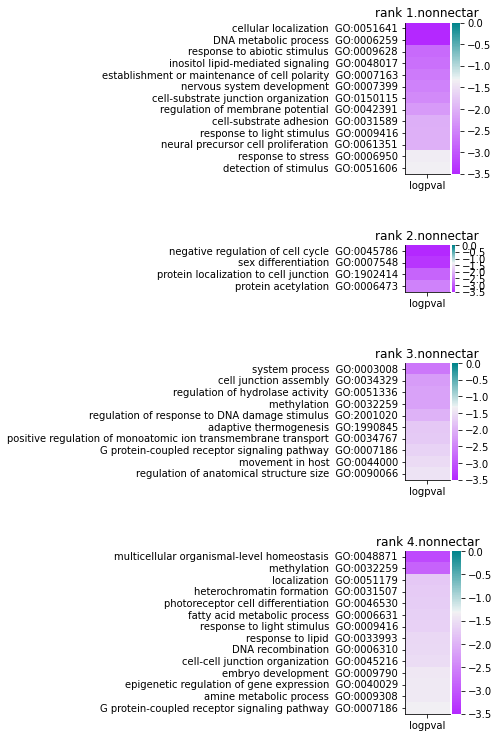

In [147]:
## Plot GO enrichments for representative GO
v = 'combined_default_srv_mh' 
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{}/ClusterProfiler/'.format(v)

# target = 'nectar'
target = 'nonnectar'
dbs = [str(i) + '.' + target for i in range(1, 5)]

## Load data
DF_dbs = {}
nonzero_dbs = []
for db in dbs:
#     file_name = 'PopGen_{}/SF2.go_enrich.1Mb_domain.tsv'.format(db)
    file_name = 'represent_GO.rank{}.tsv'.format(db)
    print(file_name)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
 
    if df.shape[0] > 0:
        print('yes')
        df['GOfull'] = df['TERM'] + '  ' + df['ancestral']
        df['logpval'] = np.log10(df['minpval'])
        DF_dbs[db] = df
        nonzero_dbs.append(db)


## Plot heatmaps
db_ratios = [DF_dbs[db].shape[0] for db in nonzero_dbs]
fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': db_ratios}, 
                         figsize=(1, 4*len(nonzero_dbs)))

cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)
vmin = -3.5
divnorm_pval = DivergingNorm(vmin=vmin, vmax=0, vcenter=np.log10(0.051))


i = 0
for db in nonzero_dbs:
    axi = axes[i]
    dfi = DF_dbs[db]
    dfi.set_index('GOfull', inplace=True)
        
    pval_cols = [i for i in dfi.columns if i.startswith('logpval')]
    df_pval = dfi[pval_cols]

    sns.heatmap(ax=axi, data=df_pval, cmap=cmap_pval, norm=divnorm_pval)
    
    axi.set_title('rank {}'.format(db))
    axi.set_ylabel('')
    axi.set_xlabel('')
    axi.legend([], [], frameon=False)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False) 
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)
fig.tight_layout()

pdf_name = 'represent_GO.all_ranks.enirch.nectar.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')